In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
import json 

from glob import glob 

import slidingwindow as sw 

from modules.utils import generateForNumberOfWindows

from copy import deepcopy

In [2]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

from skimage.measure import label, regionprops

In [3]:
from pycococreatortools import create_image_info, create_annotation_info

In [4]:
root_dir = '//172.16.113.151/UOS-SSaS Dropbox/05. Data/02. Training&Test/013. General Concrete Damage/v0.1.1'

img_dir = os.path.join(root_dir, 'leftImg8bit', 'train')
img_list = glob(os.path.join(img_dir, '*.png'))


In [5]:
import datetime

INFO = {
    "description": "Concrete Damage Dataset",
    "version": "1.0",
    "year": 2018,
    "contributor": "UOS-SSaS",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
    }
]

CATEGORIES = []

CLASSES = ['crack', 'effl', 'rebar', 'spall']

for i, name in enumerate(CLASSES):
    cat = {'id': i, 'name': name, 'supercategory': 'concrete_damage'}
    CATEGORIES.append(cat)


coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}


In [6]:
def create_normal_annotation(coco_output, gt, img_id, width, height, class_idx, segmentation_id):
    gt_label = label(gt == class_idx)

    category_info = {'id': class_idx - 1, 'is_crowd': 0}

    for label_idx in range(1, np.max(gt_label)+1):
        binary_mask = gt_label == label_idx

        annotation_info = create_annotation_info(
            segmentation_id, img_id, category_info, binary_mask, (width, height), tolerance=2
        )

        if annotation_info is not None:
            coco_output["annotations"].append(annotation_info)

        segmentation_id += 1

    return coco_output, segmentation_id

In [7]:
def create_overlap_annotation(coco_output, gt, img_id, width, height, class_idx, segmentation_id, window_size = 256, overlap = 0.5):
    gt_label = label(gt == class_idx)
    # get regionprops
    props = regionprops(gt_label)

    category_info = {'id': class_idx - 1, 'is_crowd': 0}

    for label_idx in range(1, np.max(gt_label)+1):
        binary_mask = gt_label == label_idx

        # extract bounding box
        minr, minc, maxr, maxc = props[label_idx-1].bbox

        # check bounding box size
        # if bounding box is smaller than 10, skip
        if (maxr - minr) < 10 and (maxc - minc) < 10:
            pass

        # else if bounding box is smaller than 256, create normal annotation
        elif (maxr - minr) < window_size and (maxc - minc) < window_size:
            annotation_info = create_annotation_info(
            segmentation_id, img_id, category_info, binary_mask, (width, height), tolerance=2
            )

            if annotation_info is not None:
                coco_output["annotations"].append(annotation_info)

            segmentation_id += 1

        # else if bounding box is bigger than 256, create overlap annotation
        else:

            _binary_mask = deepcopy(binary_mask)
            # coordinate of grid 
            x = np.arange(minc, maxc, int(window_size * overlap))
            y = np.arange(minr, maxr, int(window_size * overlap))

            # remove the pixels of binary_mask on the grid edge
            for i in range(1, len(x), 2):
                _binary_mask[:, x[i]] = 0

            for i in range(1, len(y), 2):
                _binary_mask[y[i], :] = 0

            # get label of binary_mask 
            label_mask = label(_binary_mask)
            
            for label_idx in range(1, np.max(label_mask)+1):
                label_obj = label_mask == label_idx

                if np.sum(label_obj) > 50:

                    annotation_info = create_annotation_info(
                        segmentation_id, img_id, category_info, label_obj, (width, height), tolerance=2
                        )

                    if annotation_info is not None:
                        coco_output["annotations"].append(annotation_info)

                    segmentation_id += 1

            _binary_mask = deepcopy(binary_mask)

            for i in range(2, len(x), 2):
                _binary_mask[:, x[i]] = 0

            for i in range(2, len(y), 2):
                _binary_mask[y[i], :] = 0

            # get label of binary_mask 
            label_mask = label(_binary_mask)
            
            for label_idx in range(1, np.max(label_mask)+1):
                label_obj = label_mask == label_idx

                if np.sum(label_obj) > 50:

                    annotation_info = create_annotation_info(
                        segmentation_id, img_id, category_info, label_obj, (width, height), tolerance=2
                        )

                    if annotation_info is not None:
                        coco_output["annotations"].append(annotation_info)

                    segmentation_id += 1


    return coco_output, segmentation_id

In [8]:
segmentation_id = 1

for idx, img_path in enumerate(img_list):

    # read images 
    img = cv2.imread(img_path)
    img_id = idx+1

    # create image info
    image_info = create_image_info(
        image_id=img_id, 
        file_name=os.path.basename(img_path), 
        image_size=img.shape[:2]
    )
    coco_output["images"].append(image_info)

    # read gt
    gt_path = img_path.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
    gt_path = gt_path.replace("leftImg8bit", "gtFine")
    
    gt = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)

    for class_idx, class_name in enumerate(CLASSES):

        class_idx += 1
        
        if class_idx == 1 or class_idx == 3:
            coco_output, segmentation_id = create_overlap_annotation(coco_output, gt, img_id, img.shape[1], img.shape[0], class_idx, segmentation_id)
        
        elif class_idx == 2 or class_idx == 4:
            coco_output, segmentation_id = create_normal_annotation(coco_output, gt, img_id, img.shape[1], img.shape[0], class_idx, segmentation_id)
            


with open(os.path.join(root_dir, 'instances_train2018.json'), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)
    



d:\CHALK\preprocessing\pycococreatortools.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.subtract(contours, 1)


//172.16.113.151/UOS-SSaS Dropbox/05. Data/02. Training&Test/013. General Concrete Damage/v0.1.0\leftImg8bit\train\con_dmg_1591422758__leftImg8bit.png


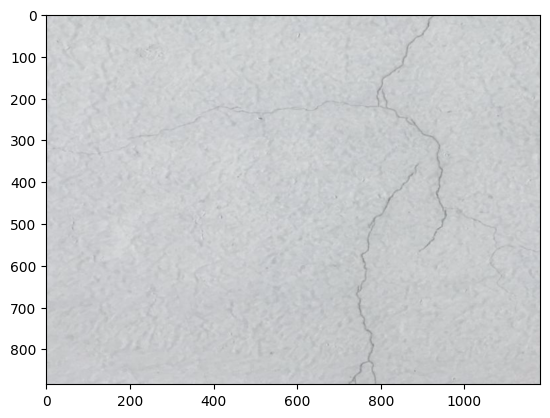

In [561]:
img_path = img_list[1000]
img = cv2.imread(img_path)
print(img_path)
plt.imshow(img)

In [562]:
# img path to label path
label_path = img_path.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
label_path = label_path.replace("leftImg8bit", "gtFine")

In [563]:
class_idx = 1

label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
label = label == class_idx 

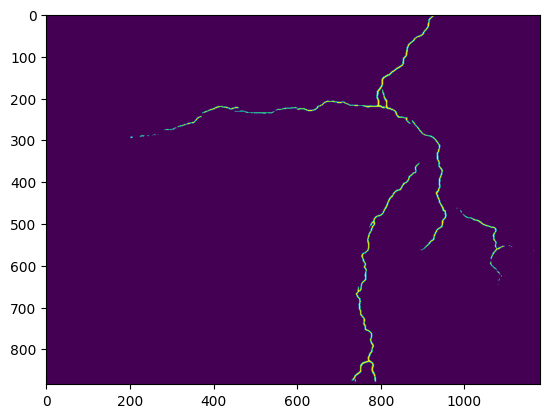

In [564]:
plt.imshow(label)

In [565]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

from skimage.segmentation import mark_boundaries

# import skimage label 
from skimage.measure import label, regionprops

SLIC number of segments: 34


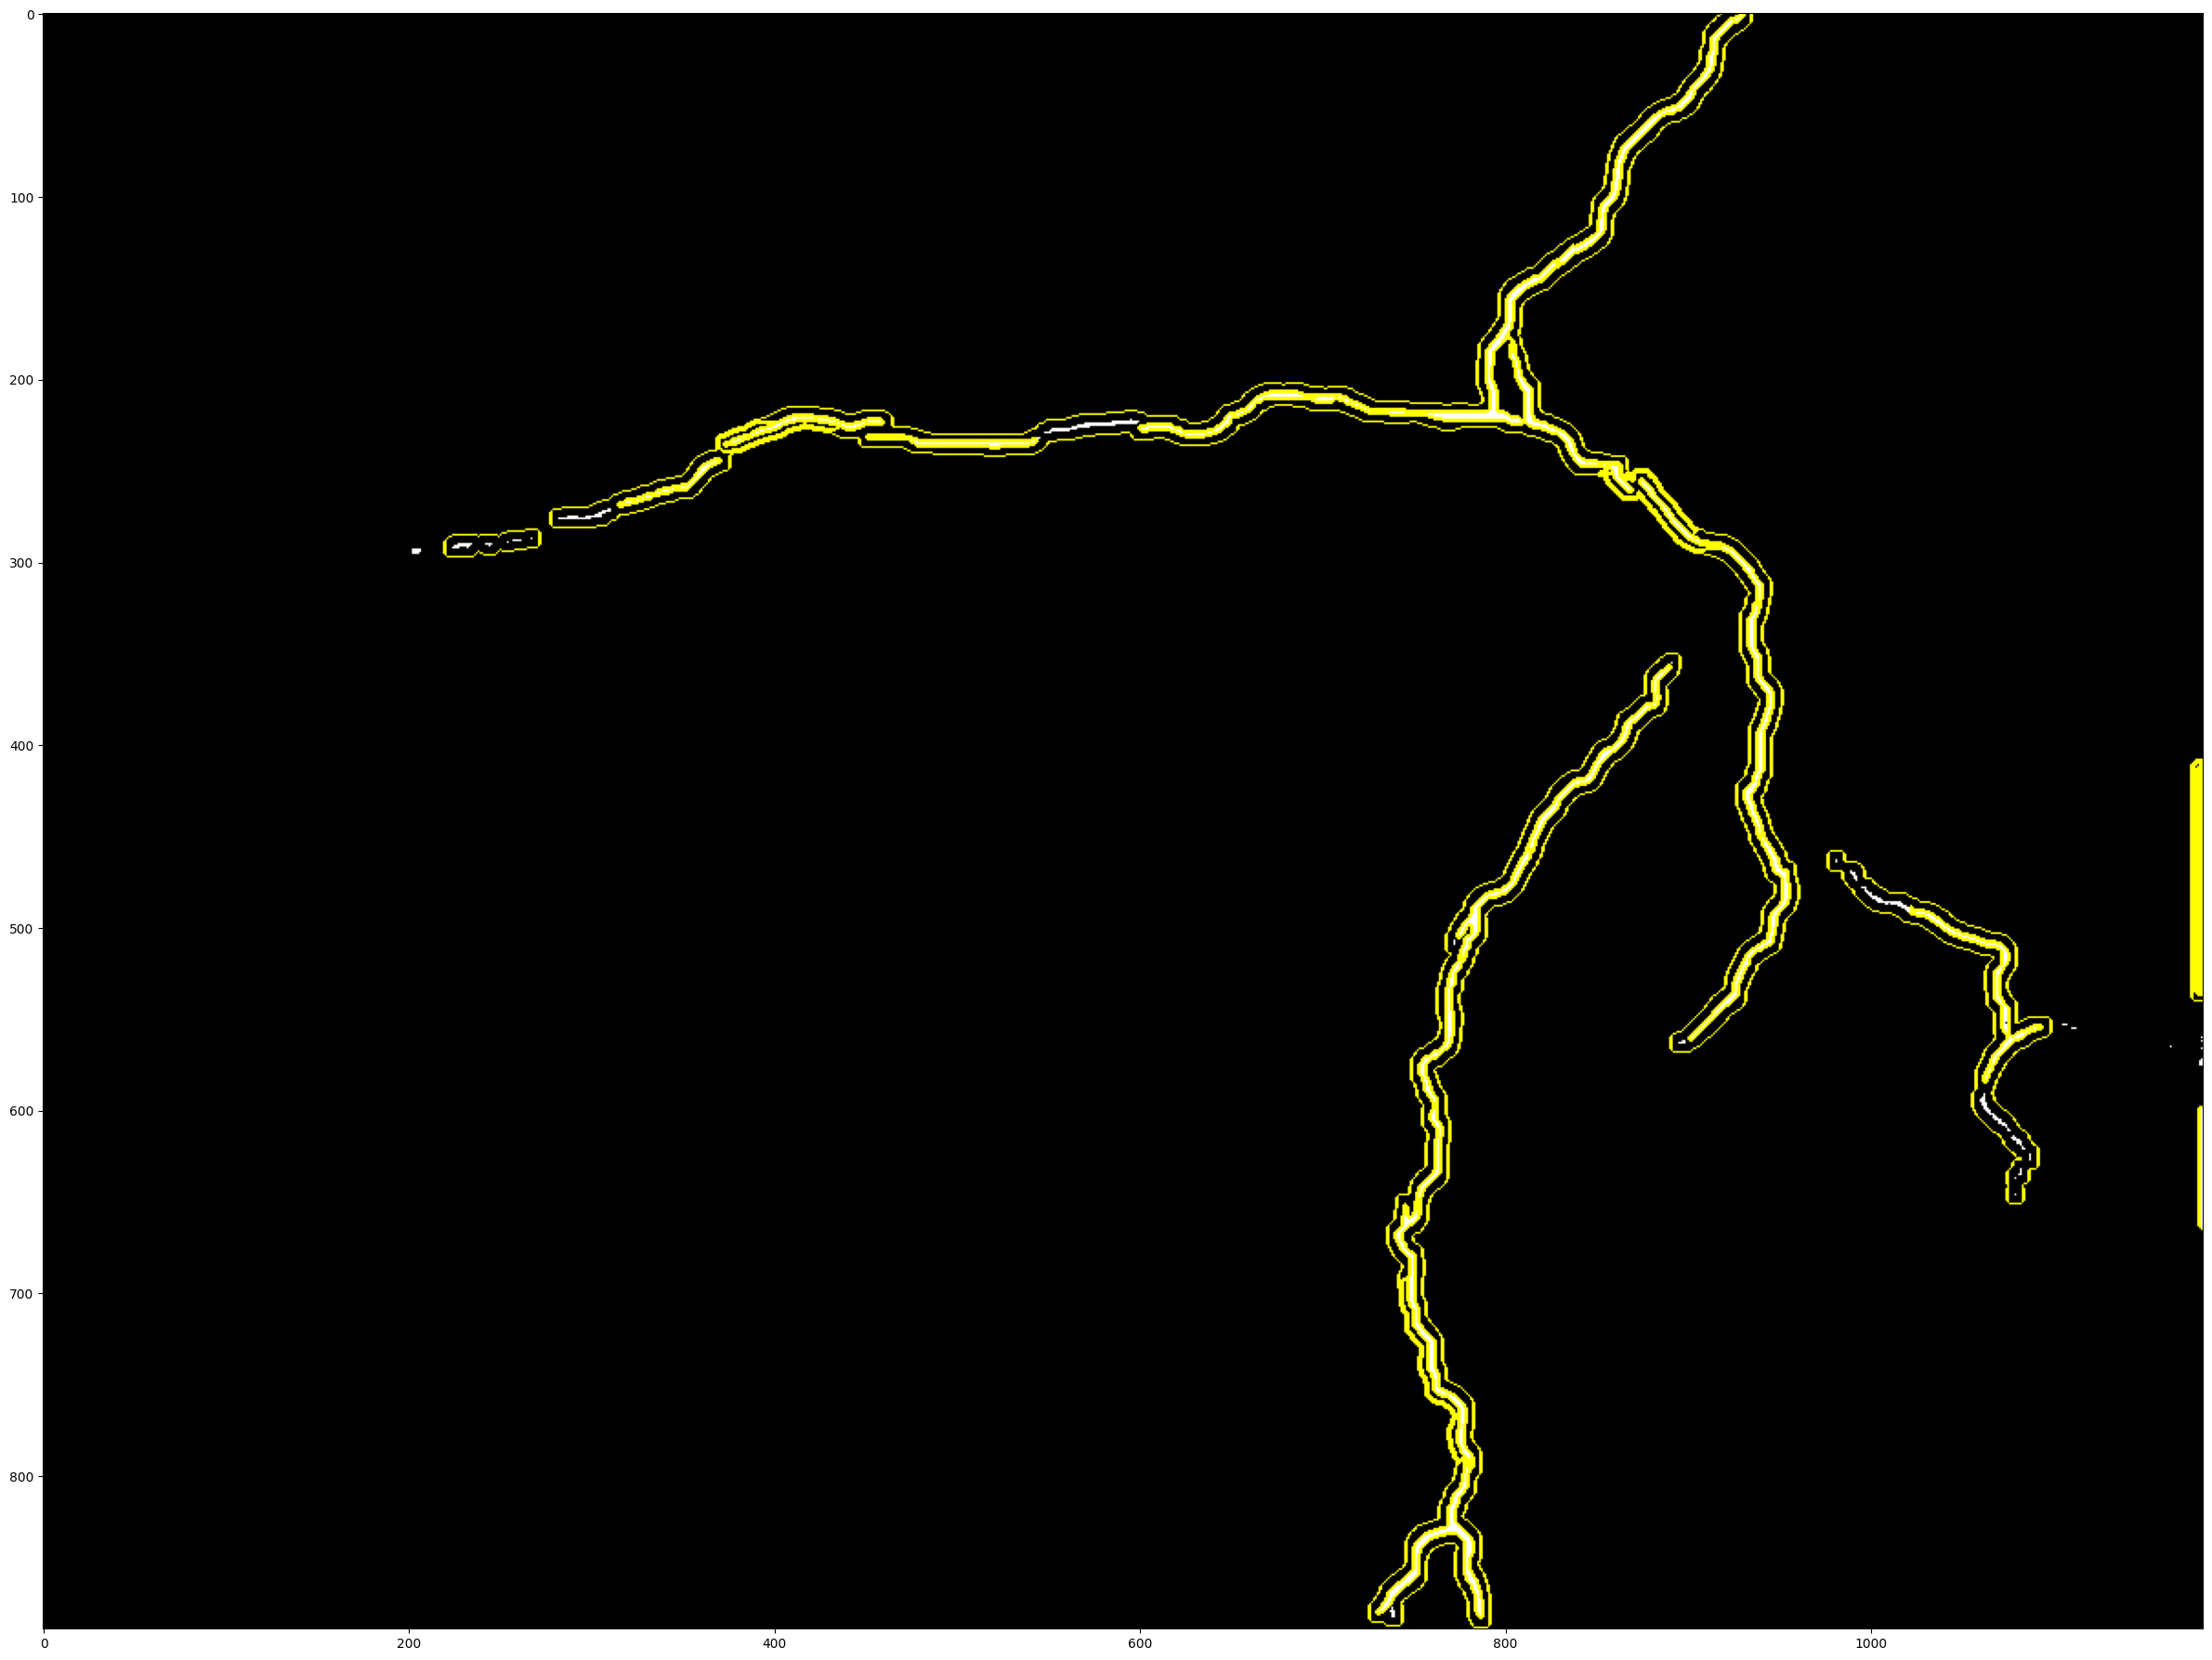

In [570]:
gt = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
gt = gt == class_idx

# label_gt = label(gt)

# gt = label_gt == 1

gt = gt.astype(np.uint8)
gt = gt * 255

# label to 3 channel
gt = cv2.cvtColor(gt, cv2.COLOR_GRAY2BGR)
if class_idx == 1:
    # gt_segment = slic(gt, n_segments=100, compactness=10, sigma=20)
    gt_segment = felzenszwalb(gt, scale=10, sigma=1, min_size=100)
else: 
    gt_segment = slic(gt, n_segments=50, compactness=100, sigma=1)
#label_segment = quickshift(label, kernel_size=3, max_dist=6, rat5io=0.5)

print(f'SLIC number of segments: {len(np.unique(gt_segment))}')
plt.figure(figsize=(30, 30))
plt.imshow(mark_boundaries(gt, gt_segment))